<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Nell2/Optimize_Masking_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

####
from IPython.display import clear_output

import numpy as np
import pandas as pd
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
import os
import tifffile
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models
clear_output()

In [2]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

In [197]:




def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    # print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image




def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image.copy(),dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:].copy()
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim

def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return exp_masks, exp_masks




def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
    
    

    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    targ_sig_nR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']<t])
    targ_sig_iR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']>t])

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,
               'targ_sig_nR':targ_sig_nR,
               'targ_sig_iR':targ_sig_iR}

    cell_df['Pos']=cell_df['mean_mCherry']>t
    mean_target_negative = np.mean(cell_df['raw_mean_target'][np.logical_not(cell_df['Pos'].values)])
    cell_df['target_norm'] = cell_df['raw_mean_target'] / mean_target_negative
    cell_df['target_norm_NEG'] = cell_df['target_norm'][np.logical_not(cell_df['Pos'].values)]
    cell_df['target_norm_POS'] = cell_df['target_norm'][cell_df['Pos']]

    results=pd.DataFrame(data=results,index=[0])


    return results, cell_df



def plot_sample(fov,inset_xy=None,pxl_per_um=800/159.1,title=None,zi=0,mask=None):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    plot_norm = fov['image_znorm'].copy()
    for ch in range(plot_norm.shape[0]):
        plot_norm[ch,:,:,:] = np.clip(plot_norm[ch,:,:,:],-1.5,1.5)+1.5

    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    if inset_xy is not None: fig_sample, axs = plt.subplots(2,4,figsize=(20,10))
    else: fig_sample, axs = plt.subplots(1,4,figsize=(20,5))
    
    axs=axs.flatten()
    axs[0].imshow(plot_norm[2,zi,:,:],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(plot_norm[1,zi,:,:],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(plot_norm[0,zi,:,:],cmap=cmap,vmax=2)


    w_sig = fov['image_znorm'][2,zi,:,:]
    w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = fov['image_znorm'][1,zi,:,:]
    r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = fov['image_znorm'][0,zi,:,:]
    g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    gain = 2
    merge = w_chan + r_chan + g_chan
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)

    if inset_xy is not None:
        y1,y2,x1,x2, = inset_xy
        my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
        axs[0].add_patch(my_rect)

        # fig, axs = plt.subplots(1,4,figsize=(32,8))
        # axs=axs.flatten()
        axs[4].imshow(plot_norm[2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
        axs[5].imshow(plot_norm[1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
        axs[6].imshow(plot_norm[0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
        axs[7].imshow(merge[x1:x2,y1:y2,:])

        sb_x = (x2-x1)*.975
        sb_y = (y2-y1)*.025
        small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
        axs[4].add_patch(small_scale_bar)


    for a in axs:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
        
    if mask is not None:
        mask_bin = mask[zi,:,:]>0
        edge_bin = skimage.filters.sobel(mask[zi,:,:])>0
        print(edge_bin.shape)
        for a in axs[:4]:
            a.contour(edge_bin)
        for a in axs[4:]:
            a.contour(edge_bin[x1:x2,y1:y2])


    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout(pad=1.1)
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')
    
    return None


def load_or_gen_mask(image_r,cell_chan,diameter,exp_dist,file_name,mask_dir=None):
    if mask_dir is not None:
        mask_files = get_sub_files(mask_dir)
        # pot_masks = get_sub_files(mask_dir)
        # pot_masks.sort()
        _ = [print('Found mask: '+ f) for f in mask_files]
    else: mask_files=[]
    mask_file_name = file_name.split('.')[0].split('/')[-1] + '_mask.tiff'
    print(f'searching for {mask_file_name}')

    find_match = [i for i in range(len(mask_files)) if mask_file_name in mask_files[i]]
    if len(find_match)>0:
        prev_mask_filename = mask_files[find_match[0]]
        print(f'load existing mask ({prev_mask_filename})')
        masks = tifffile.imread(prev_mask_filename)
        print('masks.shape',masks.shape)
        masks=masks.astype(float)
        exp_masks = masks.copy()
        for zi in range(masks.shape[0]):
            if exp_dist<0:
                circle = skimage.morphology.disk(abs(exp_dist))
                exp_masks[zi,:,:] = skimage.morphology.erosion(exp_masks[zi,:,:], selem=circle)
            else:
                exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    else: 
        print('generate new mask')
        image_r_plusred = image_r.copy()
        # image_r_plusred[2,:,:,] = (image_r_plusred[2,:,:,] + image_r_plusred[1,:,:,])/2
        masks, exp_masks = mask_image_cellpose(image_r_plusred,cell_chan,diameter,exp_dist)
        tifffile.imsave(os.path.join('Image_Masks',mask_file_name),masks)
    return masks, exp_masks



def image_pipeline(image_name,chan_dim,cell_chan,z_dim,mask_dir,t=0,exp_dist = 5,):
    # try:
    image = read_image(image_name)


    if image.shape[chan_dim]==4:
        image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )
    image=np.sum(image,axis=z_dim)
    # image = np.percentile(image,80,axis=z_dim)
    image=np.stack([image,image],axis=z_dim)
    image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
    diameter = 30
    

    # mask_dir = get_drobox_folder('https://www.dropbox.com/sh/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa?dl=0', 'Image_Masks')
    clear_output()
    masks, exp_masks = load_or_gen_mask(image_r,cell_chan,diameter,exp_dist,image_name,mask_dir)
    # masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
    print(masks.shape, 'vs', image_znorm.shape)
    print(str(np.max(exp_masks.flatten())) + ' cells in mask')
    cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
    print(cell_df.columns)
    results,cell_df = calc_odd(cell_df,t)
    cur_image_name= os.path.basename(image_name).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in cur_image_name][0]
    cell_df.to_csv( cur_image_name+'Cell_Stats.csv')

    

    fov_dict = {'image_name':image_name,
                'raw_image':image,
                'image_r':image_r,
                'image_znorm':image_znorm,
                'masks':masks,
                'exp_masks':exp_masks,
                'cell_df':cell_df,
                'results':results,
                }

    # inset_xy =  [150,350,0,200]
    plot_sample(fov_dict)
    plot_sample(fov_dict,mask=exp_masks)
    # except: print(image_name)
    
    return fov_dict



(array([3.805068e+06, 3.309200e+04, 1.108000e+03, 2.420000e+02,
        1.260000e+02, 6.200000e+01, 6.400000e+01, 7.200000e+01,
        9.800000e+01, 6.800000e+01]),
 array([-1.2649975 ,  3.93098444,  9.12696638, 14.32294832, 19.51893026,
        24.71491221, 29.91089415, 35.10687609, 40.30285803, 45.49883997,
        50.69482191]),
 <a list of 10 Patch objects>)

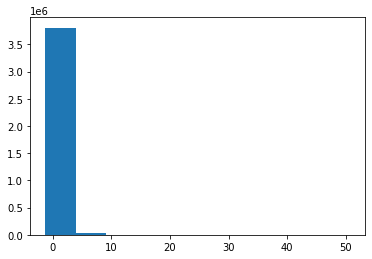

In [181]:
plt.hist(fov['image_znorm'].flatten())

In [ ]:
import shutil
if os.path.isdir('/content/Image_Masks'): shutil.rmtree('/content/Image_Masks')
data_drop_folder = 'https://www.dropbox.com/sh/dbuo3g9pd598xmw/AABx6mF-MN7Pyhr4xZWmOfWka?dl=0' # NELL2
mask_dir = get_drobox_folder('https://www.dropbox.com/sh/9183tn13gv1ixui/AABUOQ5jcp6QzuwjBwdbi3WPa?dl=0', 'Image_Masks')
data_folder = get_drobox_folder(data_drop_folder, 'images')
file_list = get_sub_files(data_folder)
file_list.sort()
file_list = [f for f in file_list if 'DAPI' not in f]
# print(file_list)
file_list = [f for f in file_list if 'NoPos' not in f]
# print(file_list)


Found mask: /content/Image_Masks/Nell2_08-10-22__S001_CA3_40X_2XZoom_2_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_S001_DG_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-09-22_DG_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_S002_DG_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_DG_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_S002_CA3_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-09-22_CA3_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-10-22_CA3_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-04-22_S001_CA3_40X_2XZoom_1_mask.tiff
Found mask: /content/Image_Masks/Nell2_08-10-22_DG_40X_2XZoom_1_mask.tiff
searching for Nell2_08-10-22__S001_DG_40X_2XZoom_2_mask.tiff
generate new mask
(2, 800, 800) vs (3, 2, 800, 800)
83.0 cells in mask


Index(['size', 'mean_target', 'raw_mean_target', 'mean_mCherry',
       'raw_mean_mCherry', 'mean_NeuN', 'raw_mean_NeuN'],
      dtype='object')


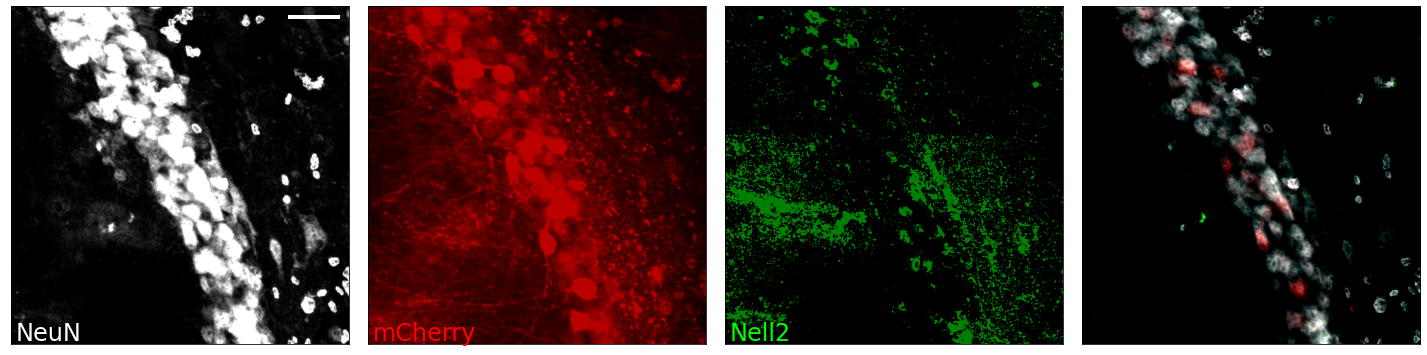

(800, 800)


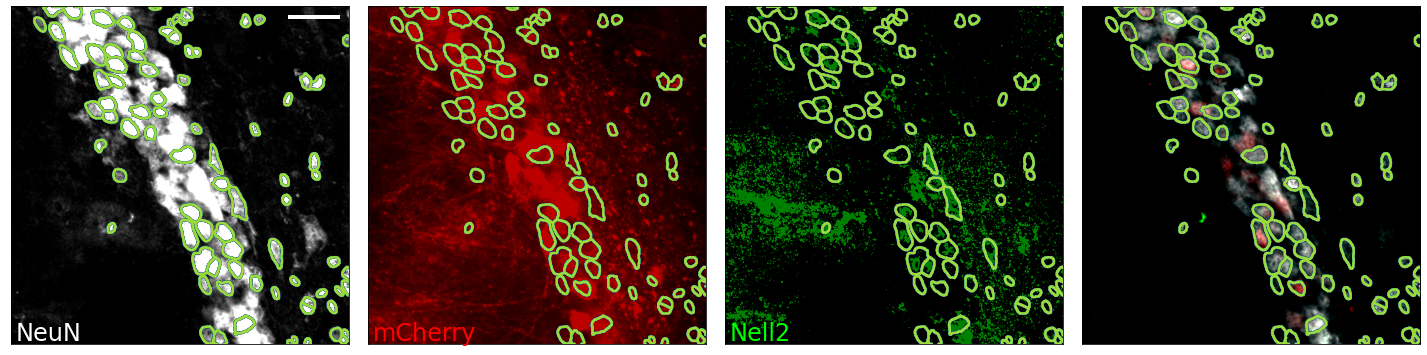

In [198]:
import shutil
if os.path.isdir('/content/Image_Masks'): shutil.rmtree('/content/Image_Masks')

exp_dist = 0
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
t = 0
ch_names = ['target','mCherry','NeuN']
mask_dir = '/content/Image_Masks'
try: os.makedirs(mask_dir)
except: None
image_results_list=[]
for f in file_list:
    # try: 
    fov = image_pipeline(f,chan_dim,cell_chan,z_dim,mask_dir,t=1.5,exp_dist=exp_dist)
    image_results_list.append(fov)
    # except: None
    # print(np.sum(f['cell_df']['Pos']), ' of ', len(f['cell_df']))

In [188]:
print(image_results_list)

[]


In [ ]:
!zip -r /content/Image_Masks.zip /content/Image_Masks
files.download('Image_Masks.zip')

  adding: content/Image_Masks/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ValueError: ignored

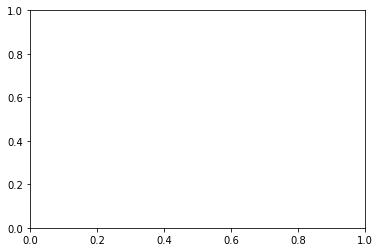

In [187]:
count_pos_list=[]
count_neg_list=[]
for f in image_results_list:
    # count_neg, bin_neg,_ = ax.hist(f['cell_df']['target_norm_NEG'],np.arange(0,12,.5),color='k', density=True, cumulative=True, label='NEG',histtype='step', alpha=0.8,)
    # count_pos, bin_pos,_ = ax.hist(f['cell_df']['target_norm_POS'],np.arange(0,12,.5),color='r',  density=True,  cumulative=True, label='POS',histtype='step', alpha=0.8,)
    # ax.set_xlabel('Target_Signal')
    # ax.set_ylabel('CDF')
    bins = np.arange(-.5,6,.25)
    count_neg, bin_neg = np.histogram(f['cell_df']['target_norm_NEG'],bins, density=True)
    count_neg = np.cumsum(count_neg)*(bin_neg[1]-bin_neg[0])

    count_pos, bin_pos = np.histogram(f['cell_df']['target_norm_POS'],bins, density=True)
    count_pos = np.cumsum(count_pos)*(bin_pos[1]-bin_pos[0])

    count_pos_list.append(count_pos)
    count_neg_list.append(count_neg)

fig,ax = plt.subplots(1)
pos_counts = np.stack(count_pos_list)
n = pos_counts.shape[0]
pos_sem = np.nanstd(pos_counts,axis=0)/np.sqrt(pos_counts.shape[0])
ax.scatter(bin_neg[:-1],np.nanmean(pos_counts,axis=0),color='r')
ax.errorbar(bin_neg[:-1],np.nanmean(pos_counts,axis=0),yerr=pos_sem,color='r')

neg_counts = np.stack(count_neg_list)
neg_sem = np.nanstd(neg_counts,axis=0)/np.sqrt(neg_counts.shape[0])
ax.scatter(bin_neg[:-1],np.nanmean(neg_counts,axis=0),color='k')
ax.errorbar(bin_neg[:-1],np.nanmean(neg_counts,axis=0),yerr=neg_sem,color='k')

ax.set_xlabel('Target_Signal')
ax.set_ylabel('CDF')

In [185]:
for f in image_results_list:
    print(f['image_name'])
    print(np.sum(f['cell_df']['Pos']), ' of ', len(f['cell_df']))
    plot_sample(f,mask=f['exp_masks'])

images/To_analyze/Nell2_08-04-22_DG_40X_2XZoom_1.oir
10  of  122


TypeError: ignored

In [176]:
# def score_image(image,chan_dim,cell_chan):
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
t = 1
ch_names = ['Nell2','mCherry','NeuN']
image_name = file_list[0]
print(image_name)

image = read_image(image_name)

image = image[:,:,:,7:9]

if image.shape[chan_dim]==4:
    image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )
image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
diameter = 45
exp_dist = 5



def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist, mask_dir):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False,net_avg=True,resample=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return masks, exp_masks

masks, exp_masks = mask_image_cellpose(image_r[:,:,:,:],cell_chan,diameter,exp_dist)

fov_dict = {'image_name':image_name,'raw_image':image,'image_znorm':image_znorm,'masks':masks,'exp_masks':exp_masks}
plot_sample(fov_dict,title=fov_dict['image_name'],zi=1,mask=masks) # inset_xy =  [150,350,0,200]

images/To_analyze/Nell2_08-04-22_DG_40X_2XZoom_1.oir


TypeError: ignored

In [ ]:

########## Mask_all
for cur_file in tqdm( file_list ):
    image=read_image(cur_file)
    if image.shape[chan_dim]==4:
        image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )
    image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
    masks, exp_masks = mask_image_cellpose(image_r[:,:,:,:],cell_chan,diameter,exp_dist)

    mask_file_name = cur_file.split('.')[0].split('/')[-1] + '_mask.tiff'
    print(mask_file_name)
    tifffile.imsave(mask_file_name,masks)

    # fov_dict = {'image_name':image_name,'raw_image':image,'image_znorm':image_znorm,'masks':masks,'exp_masks':exp_masks}
    # plot_sample(fov_dict,zi=1,mask=exp_masks) # inset_xy =  [150,350,0,200]


In [ ]:
from tqdm import tqdm
from google.colab import files
for cur_file in tqdm( file_list ):


  0%|          | 0/11 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 11/11 [00:00<00:00, 117.24it/s]


In [ ]:
### 
load_or_gen_mask(image_r,cell_chan,diameter,exp_dist,file_name,mask_dir=None)


Archive:  /content/Image_Masks.zip
mapname:  conversion of  failed
replace /content/Image_Masks/Nell2_08-04-22_DG_40X_2XZoom_1_mask.tiff? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/Image_Masks/Nell2_08-04-22_DG_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-09-22_DG_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-10-22_DG_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-09-22_CA3_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-10-22_CA3_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-04-22_S001_DG_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-04-22_S002_DG_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-04-22_S001_CA3_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-04-22_S002_CA3_40X_2XZoom_1_mask.tiff  
 extracting: /content/Image_Masks/Nell2_08-10-22__S001_CA3_40X_2XZoom_2_mask.tiff  


In [ ]:
def merge_rgbz(image):
    merge_list=[]
    for zi in range(image.shape[1]):
        w_sig = image[2,zi,:,:]
        w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
        w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
        w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
        r_sig = image[1,zi,:,:]
        r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
        r_sig = r_sig/np.percentile(r_sig.flatten(),100)
        r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
        g_sig =image[0,zi,:,:]
        g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
        g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
        g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
        gain = 2
        merge_zi = w_chan + r_chan + g_chan
        merge_list.append(merge_zi)
    merge = np.stack(merge_list)
    return merge

Archive:  /content/images.zip
mapname:  conversion of  failed
replace /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-09-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-09-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_S002_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_DG_40X_2XZoom_2.oir  
 extracting: /content/images/Nell2_08-04-22_S001_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_S002_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_CA3_40X_2XZoom_2.oir  
 extractin

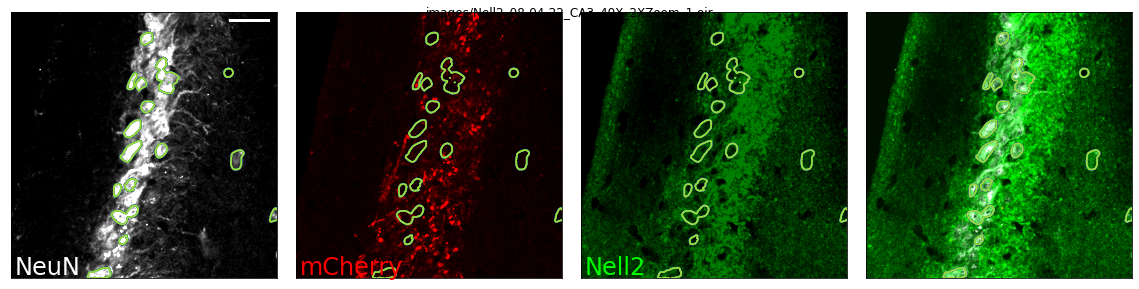

KeyboardInterrupt: ignored

In [ ]:




# # def score_image(image,chan_dim,cell_chan):



# image_name = file_list[0]

# ######################
# #####################

# image = read_image(image_name)
# if image.shape[chan_dim]==4:
#     image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )
# image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
# diameter = 40
# exp_dist = 5
# masks, exp_masks = mask_image_cellpose(image_r[:,:,:,:],cell_chan,diameter,exp_dist)
# fov_dict = {'image_name':image_name,'raw_image':image,'image_znorm':image_znorm,'masks':masks,'exp_masks':exp_masks}
# plot_sample(fov_dict,title=fov_dict['image_name'],zi=4,mask=masks) # inset_xy =  [150,350,0,200]


# cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
# results,cell_df = calc_odd(cell_df,t)
# cur_image_name= os.path.basename(image_name).split('.')[0]
# potential_targets = ['MDGA2','Nell2','RNF182']
# target_name = [t for t in potential_targets if t in cur_image_name][0]
# cell_df.to_csv( cur_image_name+'Cell_Stats.csv')


# fov_dict = {'image_name':image_name,
#             'raw_image':image,
#             'image_r':image_r,
#             'image_znorm':image_znorm,
#             'masks':masks,
#             'exp_masks':exp_masks,
#             'cell_df':cell_df,
#             'results':results,
#             }


# # # daims=np.arange(10,80,10)
# # # mask_dict = {}
# # # for d in daims:
# # #     masks, _ = mask_image_cellpose(image_r,cell_chan,diameter=d,exp_dist=0)
# # #     mask_dict[d]=masks

# # # print(mask_dict.keys())


# # def display_cells(fov_dict,n=10):
# #     # plot_sample(fov_dict,mask=fov_dict['masks'])

# #     cell_df = fov_dict['cell_df']
# #     pos_list = cell_df.index[cell_df['Pos']].tolist()
# #     pos_list = [int(i) for i in pos_list]
# #     pos_list_trunc = pos_list[:n+1]
# #     print(pos_list_trunc)

# #     mask = fov_dict['exp_masks']
# #     cell_id=1
# #     # for cell_id in pos_list_trunc:
# #     wher = np.where(mask==cell_id)
# #     print(np.where(mask==cell_id))
# #     top_left = [np.min(wher[1]), np.min(wher[2])]
# #     print(top_left)

    
# # display_cells(v)

In [ ]:
def display_cells(fov_dict,n=10,pos=True):
    # plot_sample(fov_dict,mask=fov_dict['masks'])

    cell_df = fov_dict['cell_df']
    is_pos = cell_df['Pos']
    if pos: to_use = is_pos
    else: to_use = np.logical_not( is_pos)
    cell_list = cell_df.index[to_use].tolist()
    cell_list = [int(i) for i in cell_list]
    cell_list_trunc = cell_list[:n+1]
    print(cell_list_trunc)

    mask = fov_dict['exp_masks']
    for cell_id in cell_list_trunc:
        wher = np.where(mask==cell_id)
        top_left = [np.min(wher[1]), np.min(wher[2])]
        bot_right = [np.max(wher[1]), np.max(wher[2])]
        zr = list(set(wher[0]))
        x1, y1 = top_left
        x2, y2 = bot_right
        sub_im = fov_dict['image_znorm'][:,zr,x1:x2,y1:y2]
        sub_im_zstk = np.sum(sub_im,axis=1)



        fig, axs = plt.subplots(1,3,figsize=(12,4))
        zi = int(np.median(zr))
        merge = merge_rgbz(fov_dict['image_znorm'])
        axs[0].imshow(fov_dict['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
        axs[1].imshow(fov_dict['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
        axs[2].imshow(fov_dict['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
        # axs[3].imshow(merge[zi,x1:x2,y1:y2,:])

        mask_edge = skimage.filters.sobel(mask[zi,x1:x2,y1:y2]>0)

        for a in axs:
            a.contour(mask[zi,x1:x2,y1:y2])

    sb_x = (x2-x1)*.975
    sb_y = (y2-y1)*.025
    # pxl_per_um
    # small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    # axs[4].add_patch(small_scale_bar)

n = 3
display_cells(fov_dict,n=n,pos=False)
display_cells(fov_dict,n=n,pos=True)

In [ ]:
############## Get red masks
image_r = fov['image_r']
exp_dist = 0
red_masks, red_exp_masks = mask_image_cellpose(image_r,1,diameter,exp_dist)
bins=np.arange(1,np.max(red_exp_masks.flatten()))
min_size = 1000
plt.hist(red_exp_masks.flatten(),bins=bins)
plt.show()
counts,_ = np.histogram(red_exp_masks.flatten(),bins=bins)
to_keep = [i+1 for i in range(len(counts)) if counts[i]>min_size]

red_exp_masks_c = np.zeros_like(red_exp_masks)
for ci in range(len(to_keep)):
    c = to_keep[ci]
    red_exp_masks_c[red_exp_masks==c] = ci
red_exp_masks = red_exp_masks_c

red_cell_df = quant_cells(fov['image_znorm'], image_r, red_exp_masks,chan_dim=0)
to_keep = np.where(red_cell_df['mean_NeuN']>0)[0]+1
red_exp_masks_c = np.zeros_like(red_exp_masks)
for ci in range(len(to_keep)):
    c = to_keep[ci]
    red_exp_masks_c[red_exp_masks==c] = ci
red_exp_masks = red_exp_masks_c
red_cell_df = quant_cells(fov['image_znorm'], image_r, red_exp_masks,chan_dim=0)
display(red_cell_df)


# # red_cell_df.columns

plot_sample(fov,mask=red_exp_masks)